
# <font size="+3"><span style='color:#861141'> **P8 - Déployez un modèle dans le cloud** </span></font>


<a id='LOADING_LIBRARIES'></a>

---

---

<font size="+1"> **LOADING THE LIBRARIES** </font>

---

In [1]:
# File system management
import os
import sys
from pathlib import Path
import io
import glob

# Data manipulation
import numpy as np
import pandas as pd
import random
import shutil

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Image manipulation
from PIL import Image

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Pyspark
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT

%matplotlib inline
sns.set_theme(palette="Set2")



2023-09-01 10:30:22.015723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

<a id='preambule'></a>

---
---

# <span style='background:#861141'><span style='color:white'>**Préambule** </span></span>



La très jeune start-up de l'AgriTech, nommée **"Fruits!", cherche à proposer des solutions innovantes pour la récolte des fruits**.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.

La start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.
Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.
De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.

**Objectifs dans ce projet**

* **Développer une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension**. 
* **Tenir compte du fait que le volume de données va augmenter très rapidement après la livraison de ce projet**, ce qui implique de:
  * Déployer le traitement des données dans un **environnement Big Data**
  * Développer les scripts en **pyspark** pour effectuer du **calcul distribué**

Le projet va être réalisé **en 2 phases**, dans deux environnements différents.
* Nous allons dans une première phase développer et exécuter notre code en **local**, en travaillant sur un nombre limité d'images à traiter.
* Une fois les choix techniques validés, nous **déploierons** notre solution dans un **environnement Big Data en mode distribué**.
**Ce notebook correspond à la première phase.**

Un alternant a formalisé un document dans lequel il teste une première approche dans un environnement Big Data. Le notebook réalisé par l’alternant servira de point de départ pour construire une partie de la chaîne de traitement des données.

**Mission**
* Reprendre les travaux réalisés par l’alternant et de **réviser et compléter la chaîne de traitement des données** avec une étape de **réduction de dimension**.
* L’important est de mettre en place les premières briques de traitement qui serviront lorsqu’il faudra passer à l’échelle en termes de volume de données.

<a id='exploration_donnees'></a>

---
---

# <span style='background:#861141'><span style='color:white'>**Exploration des données** </span></span>


In [3]:
# Define the folder containing the files with the project data
P8 = "/home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/"
os.chdir(P8)

In [4]:
PATH_DataTrain = P8+'P8_source/fruits/fruits-360_dataset/fruits-360/Training/'
PATH_DataTest = P8+'P8_source/fruits/fruits-360_dataset/fruits-360/Test/'


print('PATH Project:     '+\
      P8+'\n\nPATH_DataTrain:   '+\
      PATH_DataTrain+'\n\nPATH_DataTest:    '+\
      PATH_DataTest)

PATH Project:     /home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/

PATH_DataTrain:   /home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_source/fruits/fruits-360_dataset/fruits-360/Training/

PATH_DataTest:    /home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_source/fruits/fruits-360_dataset/fruits-360/Test/


<a id='data_train'></a>

## <span style='background:#7a1d2c'><span style='color:white'>Data Training</span></span>

In [5]:
# Count images
img_count = len([f for f in Path(PATH_DataTrain).rglob('*.jpg') if f.is_file()])
print("Number of JPG files in PATH_DataTrain : " + str(img_count))

Number of JPG files in PATH_DataTrain : 67692


In [6]:
# Create list of images
images_list = [(file_name, dir_path.split('/')[-1]) for (dir_path, _, file_names) in os.walk(PATH_DataTrain) \
               for file_name in file_names if file_name.endswith('.jpg')]

# Create dataframe
images_df = pd.DataFrame(images_list, columns=['image', 'label'])

# Add categoriesPATH_DataTrain
images_df['category'] = images_df['label'].apply(lambda x: x.split(' ')[0])
display(images_df.head())

,image,label,category
0,108_100.jpg,Apple Red 1,Apple
1,r_149_100.jpg,Apple Red 1,Apple
2,r_194_100.jpg,Apple Red 1,Apple
3,r_163_100.jpg,Apple Red 1,Apple
4,r_172_100.jpg,Apple Red 1,Apple


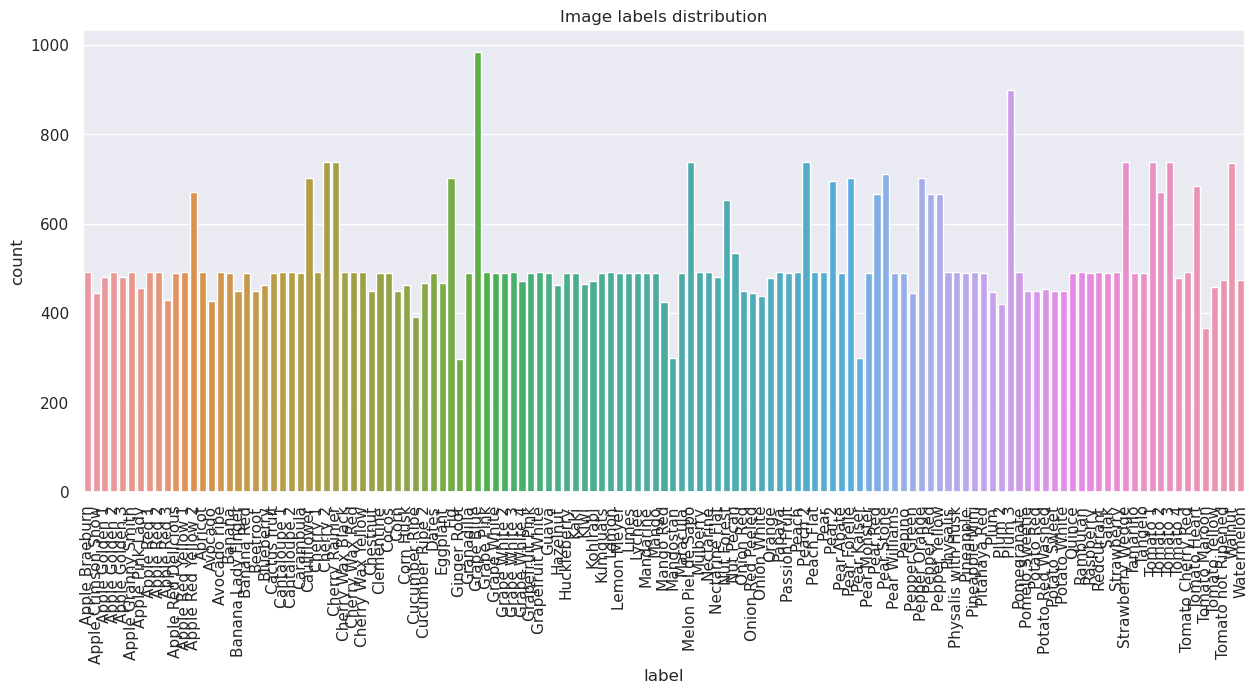

Number of labels : 131


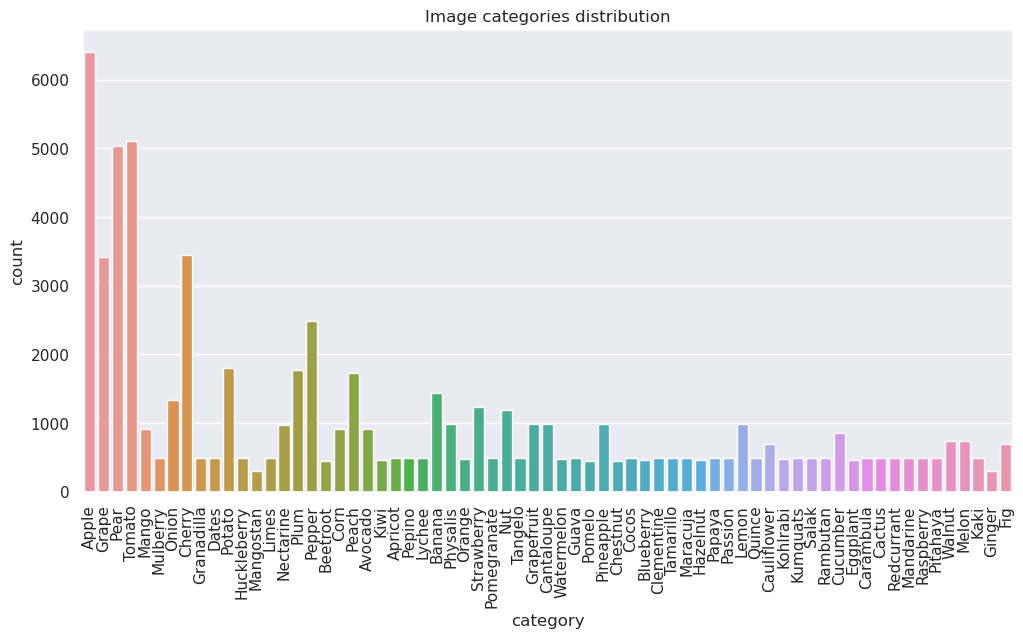

Number of categories : 67


In [7]:
# Display image labels
plt.figure(figsize=(15, 6))
plt.title("Image labels distribution")
sns.countplot(x=images_df['label'].sort_values())
plt.xticks(rotation=90)
plt.show()

print("Number of labels :", str(images_df['label'].nunique()))

# Display image categories
plt.figure(figsize=(12, 6))
plt.title("Image categories distribution")
sns.countplot(x=images_df['category'])
plt.xticks(rotation=90)
plt.show()

print("Number of categories :", str(images_df['category'].nunique()))

<a id='data_test'></a>

## <span style='background:#7a1d2c'><span style='color:white'>Data Test</span></span>

In [8]:
# Count images
img_count = len([f for f in Path(PATH_DataTest).rglob('*.jpg') if f.is_file()])
print("Number of JPG files in PATH_DataTest : " + str(img_count))

Number of JPG files in PATH_DataTest : 22688


In [9]:
# Create list of images
images_list = [(file_name, dir_path.split('/')[-1]) for (dir_path, _, file_names) in os.walk(PATH_DataTest) \
               for file_name in file_names if file_name.endswith('.jpg')]

# Create dataframe
images_df = pd.DataFrame(images_list, columns=['image', 'label'])

# Add categories
images_df['category'] = images_df['label'].apply(lambda x: x.split(' ')[0])
display(images_df.head())

,image,label,category
0,r_325_100.jpg,Apple Red 1,Apple
1,322_100.jpg,Apple Red 1,Apple
2,323_100.jpg,Apple Red 1,Apple
3,34_100.jpg,Apple Red 1,Apple
4,r_39_100.jpg,Apple Red 1,Apple


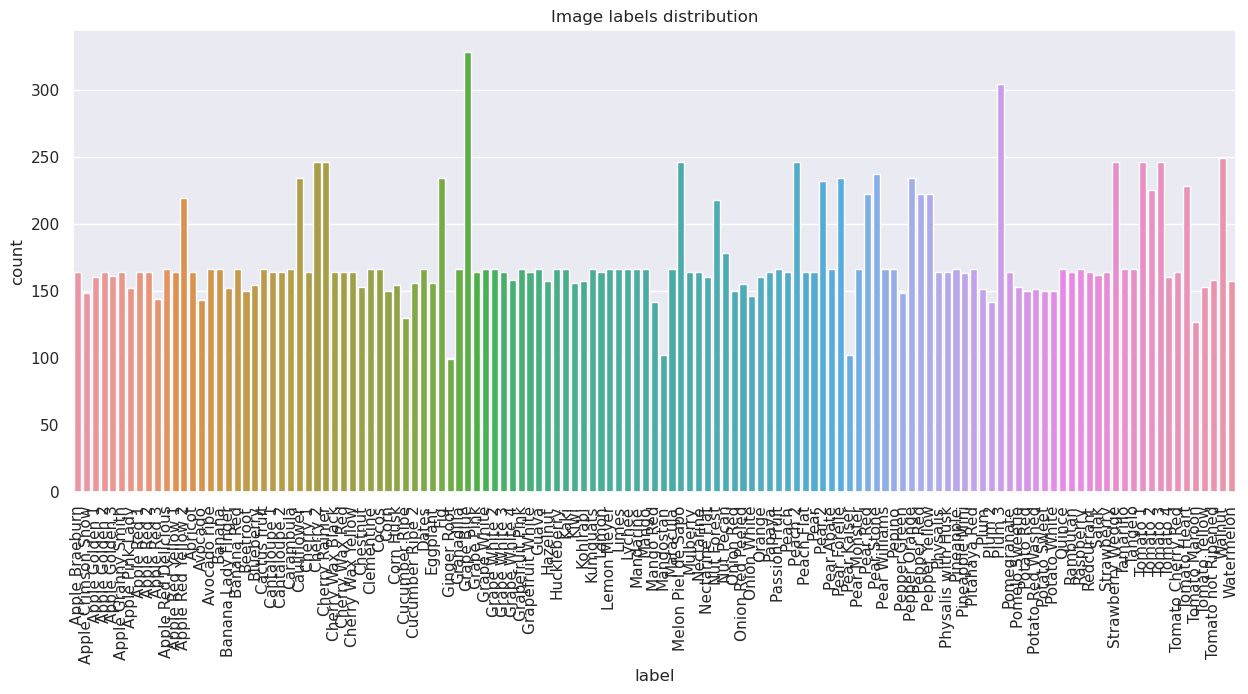

Number of labels : 131


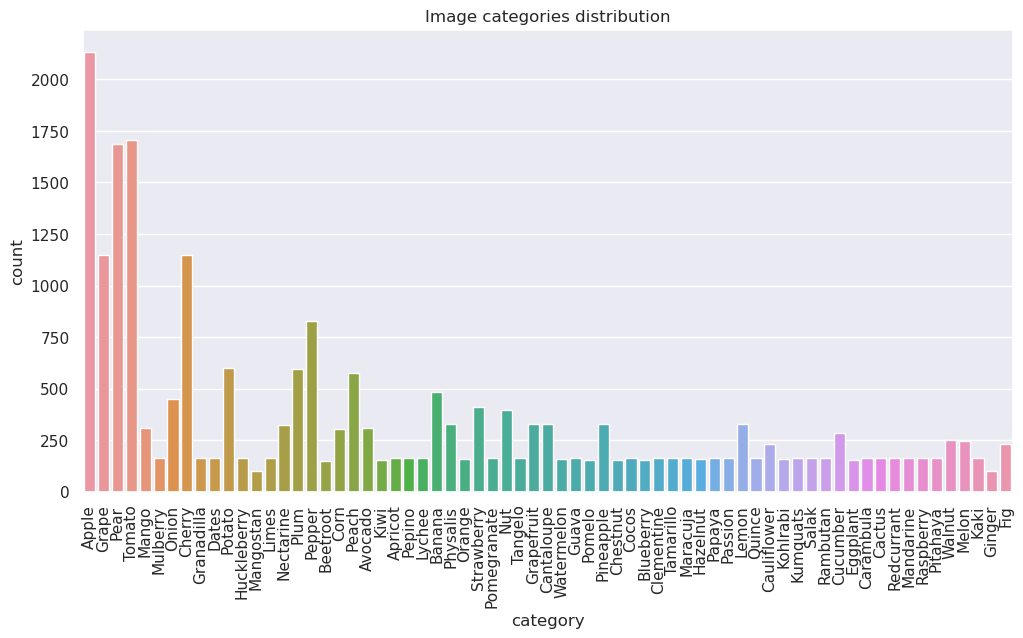

Number of categories : 67


In [10]:
# Display image labels
plt.figure(figsize=(15, 6))
plt.title("Image labels distribution")
sns.countplot(x=images_df['label'].sort_values())
plt.xticks(rotation=90)
plt.show()

print("Number of labels :", str(images_df['label'].nunique()))

# Display image categories
plt.figure(figsize=(12, 6))
plt.title("Image categories distribution")
sns.countplot(x=images_df['category'])
plt.xticks(rotation=90)
plt.show()

print("Number of categories :", str(images_df['category'].nunique()))

<a id='creation_sousechantillon_local'></a>

## <span style='background:#7a1d2c'><span style='color:white'>Création de sous-échantillons pour le développement en local</span></span>

Pour continuer dans la même direction que le travail développé par l'Alternate, nous travaillerons avec les données de Test.<br>
En raison des limitations des ressources disponibles, un **sous-échantillon de 300 images appartenant à 12 classes différentes** sera généré pour le **développement local**.

In [11]:
# Define the folders storing subsample dataset
PATH_Train = P8+'P8_travail/Train1'
PATH_Test = P8+'P8_travail/Test1/'

# Define de folder storing the Results of local development
PATH_Result = P8+'P8_travail/Results_local/'

print('PATH_Train:    '+\
      PATH_Train+'\nPATH_Test:     '+\
      PATH_Test+'\n\nPATH_Result:   '+PATH_Result)

PATH_Train:    /home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_travail/Train1
PATH_Test:     /home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_travail/Test1/

PATH_Result:   /home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_travail/Results_local/


In [12]:
print("Les images utilsées pour le développement en local sont stockées dans PATH_Test :\n" + PATH_Test)

Les images utilsées pour le développement en local sont stockées dans PATH_Test :
/home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_travail/Test1/


<a id='creation_spark_session'></a>

---
---

# <span style='background:#861141'><span style='color:white'>**Création de la SparkSession** </span></span>


L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**. <br>
<u>Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur dans l’ensemble du cluster. Une SparkSession correspond toujours à une application Spark</u>.<br>

<u>Nous créons une session spark avec les mêmes caracteristiques que celles utilisées par l'alternant</u> :
 1. **nom pour l'application**, qui sera affichée dans l'interface utilisateur Web Spark "**P8**"
 2. l'application s'exécutera **localement**. <br>
   Le nombre de cœurs n'est pas défini, l'application utilisera tous les cœurs du processeur.<br>
 3. activation d'une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** <br>
   ce format sera utilisé pour enregistrer et charger le résultat de notre travail.
 4. **obtenir une session spark** existante **ou** si aucune n'existe, en **créer** une nouvelle

In [13]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
        )

23/09/01 10:30:32 WARN Utils: Your hostname, raquelsp resolves to a loopback address: 127.0.1.1; using 192.168.1.39 instead (on interface wlp0s20f3)
23/09/01 10:30:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/01 10:30:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/01 10:30:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [14]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [15]:
spark

<a id='traitement_donnees'></a>

---
---

# <span style='background:#861141'><span style='color:white'>**Traitement des données** </span></span>


<u>Dans la suite du flux de travail, les étapes suivantes sont abordées</u> :
1. Préparation des données
    1. Importer les images dans un dataframe **pandas UDF**
    2. Associer aux images leur **label**
    3. Préprocesser en **redimensionnant les images pour qu'elles soient compatibles avec notre modèle**
2. Préparation du modèle
    1. Importer le modèle **MobileNetV2**
    2. Créer un **nouveau modèle** dépourvu de la dernière couche de MobileNetV2
3. Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF
3. Extraction de features
4. **Réduction des diménsions via un PCA**
5. Sauvegarde du résultat de nos actions
6. Vérification du bon fonctionnement, en chargeant les données enregistrées

<a id='chargement_donnees'></a>

## <span style='background:#7a1d2c'><span style='color:white'>Chargement des données</span></span>

* Les images sont chargées au format binaire, ce qui offre, plus de souplesse dans la façon de prétraiter les images.
* Seuelement les fichiers dont l'extension est **jpg** seront chargés.
* Les fichiers contenus contenus dans les sous-dossiers du dossier communiqué seront également chargés.

In [16]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Test)

In [17]:
images.show(5)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/raquel...|2023-08-24 12:28:...|  6784|[FF D8 FF E0 00 1...|
|file:/home/raquel...|2023-08-24 12:28:...|  6768|[FF D8 FF E0 00 1...|
|file:/home/raquel...|2023-08-24 12:28:...|  6767|[FF D8 FF E0 00 1...|
|file:/home/raquel...|2023-08-24 12:28:...|  6721|[FF D8 FF E0 00 1...|
|file:/home/raquel...|2023-08-24 12:28:...|  6697|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows



<u>Affichage des 5 premières images contenant</u> :
 - le path de l'image
 - la date et heure de sa dernière modification
 - sa longueur
 - son contenu encodé en valeur hexadécimal

<u>Seulement le **path** de l'image est conservé, une colonne contenant les **labels** de chaque image est ajouté</u> :

In [18]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------------------------------------------------------------+---------+
|path                                                                                                      |label    |
+----------------------------------------------------------------------------------------------------------+---------+
|file:/home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_travail/Test1/Raspberry/199_100.jpg|Raspberry|
|file:/home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_travail/Test1/Raspberry/200_100.jpg|Raspberry|
|file:/home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_travail/Test1/Raspberry/81_100.jpg |Raspberry|
|file:/home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_trav

<a id='preparation_modele'></a>

## <span style='background:#7a1d2c'><span style='color:white'>Préparation du modèle</span></span>

La technique du **transfert learning** est utilisée pour extraire les features des images.
Le modèle **MobileNetV2** a été choisi pour sa rapidité d'exécution comparée à d'autres modèles comme *VGG16* par exemple.
Pour en savoir plus sur MobileNetV2, veuillez lire [cet article](https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c).

<u>Voici le schéma de l'achitecture globale</u> : 

![Architecture de MobileNetV2](img/mobilenetv2_architecture.png)

Il existe une dernière couche qui sert à classer les images selon 1000 catégories que nous ne voulons pas utiliser.
L'idée dans ce projet est de récupérer le **vecteur de caractéristiques de dimensions (1,1,1280)** qui servira, plus tard, au travers d'un moteur de classification à reconnaitre les différents fruits du jeu de données.

Comme d'autres modèles similaires, **MobileNetV2**, lorsqu'on l'utilise en incluant toutes ses couches, attend obligatoirement des images de dimension (224,224,3). Nos images étant toutes de dimension (100,100,3), nous devrons simplement les **redimensionner** avant de les confier au modèle.

<u>Dans l'odre</u> :
 1. Le modèle **MobileNetV2** est chargé avec les poids **précalculés** issus d'**imagenet**, en spécifiant le format de nos images en entrée
 2. Un nouveau modèle est créé avec:
  - <u>en entrée</u> : l'entrée du modèle MobileNetV2
  - <u>en sortie</u> : l'avant dernière couche du modèle MobileNetV2

In [19]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

2023-09-01 10:30:37.110591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 10:30:37.111519: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Affichage du résumé de notre nouveau modèle où on constate que <u>le vecteur de sortie est bien de dimension (1, 1, 1280)</u> :

In [21]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Tous les workers doivent pouvoir accéder au modèle ainsi qu'à ses poids.
Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser ensuite les poids aux différents workers.

In [22]:
brodcast_weights = sc.broadcast(new_model.get_weights())

<u>Mettons cela sous forme de fonction</u> :

In [23]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                      outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

<a id='chargement_featurisation_udf'></a>

## <span style='background:#7a1d2c'><span style='color:white'>Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF</span></span>

Le notebook définit la logique par étapes, jusqu'à Pandas UDF.

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

In [24]:
# Resize images to 224x224
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

# Featurize images and return a series of vectors (flattened tensors)
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param: content_series_iter, This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/raquelsp/anaconda3/envs/venvP8/lib/python3.7/site-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


<a id='execution_extraction_feat'></a>

## <span style='background:#7a1d2c'><span style='color:white'>Exécution des actions d'extraction de features</span></span>

Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), peuvent rencontrer des erreurs de type Out Of Memory (OOM).
Dans le cas où de teller erreurs apparaitrent, la ligne de code dans la cellule ci-dessous, permets de retuire la taille du lot Arrow via 'maxRecordsPerBatch'.

In [25]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.<br />

In [26]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<u>Rappel du PATH où seront inscrits les fichiers au format "**parquet**" <br />
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes</u> :
 1. Path des images
 2. Label de l'image
 3. Vecteur de caractéristiques de l'image

In [27]:
print(PATH_Result)

/home/raquelsp/Documents/Openclassrooms/P8_Fruits_modele_cloud/P8_travail/Results_local/


In [28]:
features_df.show(5)

2023-09-01 10:30:39.884776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 10:30:40.887512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 10:30:40.889469: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


+--------------------+------------------+--------------------+
|                path|             label|            features|
+--------------------+------------------+--------------------+
|file:/home/raquel...|         Raspberry|[0.29254088, 1.06...|
|file:/home/raquel...|        Strawberry|[2.20994, 0.09814...|
|file:/home/raquel...|        Strawberry|[1.6356167, 0.0, ...|
|file:/home/raquel...|             Peach|[0.13757613, 0.0,...|
|file:/home/raquel...|Tomato not Ripened|[0.0, 0.4384215, ...|
+--------------------+------------------+--------------------+
only showing top 5 rows



1/1 [==============================] - 1s 845ms/step


<a id='PCA'></a>

## <span style='background:#7a1d2c'><span style='color:white'>Réduction des dimensions via PCA</span></span>

<a id='recherche_k'></a>

### <font size="+2" color="#63202b"><b>Recherche nombre de composantes optimal<b></font><br><a name="Tokenization"></a>

**Préparation des données**

In [29]:
# First step is to convert our features arrays into vectors
array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
df_with_vectors = features_df.select(
    features_df["path"],
    features_df["label"],
    features_df["features"],
    array_to_vector_udf(features_df["features"]).alias("vectorFeatures"),
)
# show the 5 first values :
df_with_vectors.show(5)

2023-09-01 10:30:43.563891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 10:30:44.580096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 10:30:44.582283: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
1/1 [==============================] - 1s 769ms/step


+--------------------+------------------+--------------------+--------------------+
|                path|             label|            features|      vectorFeatures|
+--------------------+------------------+--------------------+--------------------+
|file:/home/raquel...|         Raspberry|[0.29254088, 1.06...|[0.29254087805747...|
|file:/home/raquel...|        Strawberry|[2.20994, 0.09814...|[2.20993995666503...|
|file:/home/raquel...|        Strawberry|[1.6356167, 0.0, ...|[1.63561666011810...|
|file:/home/raquel...|             Peach|[0.13757613, 0.0,...|[0.13757613301277...|
|file:/home/raquel...|Tomato not Ripened|[0.0, 0.4384215, ...|[0.0,0.4384214878...|
+--------------------+------------------+--------------------+--------------------+
only showing top 5 rows



In [30]:
# Second step is to scale the data before applying the PCA process
scaler = StandardScaler(inputCol="vectorFeatures",
                        outputCol="scaledFeatures",
                        withMean=True, withStd=True
                        ).fit(df_with_vectors)

# when we transform the dataframe, the old feature will still remain in it
df_scaled = scaler.transform(df_with_vectors)
# show the 5 first values :
df_scaled.show(5)

1/1 [==============================] - 1s 616ms/step                (0 + 1) / 1]


+--------------------+------------------+--------------------+--------------------+--------------------+
|                path|             label|            features|      vectorFeatures|      scaledFeatures|
+--------------------+------------------+--------------------+--------------------+--------------------+
|file:/home/raquel...|         Raspberry|[0.29254088, 1.06...|[0.29254087805747...|[-0.2479661194709...|
|file:/home/raquel...|        Strawberry|[2.20994, 0.09814...|[2.20993995666503...|[3.09032401311497...|
|file:/home/raquel...|        Strawberry|[1.6356167, 0.0, ...|[1.63561666011810...|[2.09039769878233...|
|file:/home/raquel...|             Peach|[0.13757613, 0.0,...|[0.13757613301277...|[-0.5177676881965...|
|file:/home/raquel...|Tomato not Ripened|[0.0, 0.4384215, ...|[0.0,0.4384214878...|[-0.7572947915732...|
+--------------------+------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



**Recherche du nombre de composante expliquant 95% de la variance**

In [31]:
def find_number_components(dataframe, nb_comp=400):
    '''
       Finds the optimal number of components explaining 95% of variance
       : param: dataframe, features dataframe
       : return: k, number of components explaining over 95% of total variance
    '''

    pca = PCA(k = nb_comp,
              inputCol="scaledFeatures",
              outputCol="features_pca")

    model_pca = pca.fit(dataframe)
    variance = model_pca.explainedVariance

    # visuel
    plt.plot(np.arange(len(variance)) + 1, variance.cumsum(), c="red", marker='o')
    plt.xlabel("Number of components")
    plt.ylabel("% variance")
    plt.show(block=False)

    def nb_comp ():
      for i in range(500):
          a = variance.cumsum()[i]
          if a >= 0.95:
              print("{} composantes principales expliquent au moins 95% de la variance totale".format(i))
              break
      return i

    k=nb_comp()
    return k


1/1 [==============================] - 1s 752ms/step===========>  (19 + 1) / 20]
23/09/01 10:32:38 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/09/01 10:32:38 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


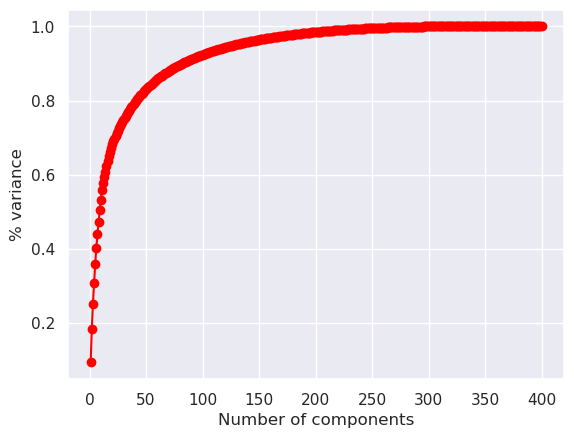

128 composantes principales expliquent au moins 95% de la variance totale


In [32]:
# Nombre de composante expliquant 95% de la variance
n_components = find_number_components(df_scaled)

<a id='reduc_dim'></a>

### <font size="+2" color="#63202b"><b>Réduction de dimensions via PCA<b></font><br><a name="Tokenization"></a>

In [33]:
# Apply the PCA with n_components
pca = PCA(k=n_components, inputCol='scaledFeatures', outputCol='pcaFeatures')

model_pca = pca.fit(df_scaled)
df_pca = model_pca.transform(df_scaled)

# show the 5 first values :
df_pca.show(5)

1/1 [==============================] - 1s 633ms/step===========>  (19 + 1) / 20]
23/09/01 10:34:02 WARN DAGScheduler: Broadcasting large task binary with size 1352.1 KiB


+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|                path|             label|            features|      vectorFeatures|      scaledFeatures|         pcaFeatures|
+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|file:/home/raquel...|         Raspberry|[0.29254088, 1.06...|[0.29254087805747...|[-0.2479661194709...|[-18.915042887680...|
|file:/home/raquel...|        Strawberry|[2.20994, 0.09814...|[2.20993995666503...|[3.09032401311497...|[-19.988846857832...|
|file:/home/raquel...|        Strawberry|[1.6356167, 0.0, ...|[1.63561666011810...|[2.09039769878233...|[-31.014341250894...|
|file:/home/raquel...|             Peach|[0.13757613, 0.0,...|[0.13757613301277...|[-0.5177676881965...|[-3.0016836093650...|
|file:/home/raquel...|Tomato not Ripened|[0.0, 0.4384215, ...|[0.0,0.4384214878...|[-0.7572947915732...|[3.81594761774

1/1 [==============================] - 1s 611ms/step


<a id='enreg_resultats'></a>

## <span style='background:#7a1d2c'><span style='color:white'>Enregistrement des résultats</span></span>

<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [34]:
df_results = df_pca.select(["path", "label", "pcaFeatures"])

In [35]:
df_results.write.mode("overwrite").parquet(PATH_Result)

23/09/01 10:34:04 WARN DAGScheduler: Broadcasting large task binary with size 1547.3 KiB
1/1 [==============================] - 1s 694ms/step===========>  (19 + 1) / 20]


<a id='validation'></a>

## <span style='background:#7a1d2c'><span style='color:white'>Chargement des données enregistrées et validation du résultat</span></span>

<u>On charge les données fraichement enregistrées dans un **DataFrame Pandas**</u> :

In [36]:
df = spark.read.parquet(PATH_Result).toPandas()

<u>On affiche les 5 premières lignes du DataFrame</u> :

In [37]:
df.head()

,path,label,pcaFeatures
0,file:/home/raquelsp/Documents/Openclassrooms/P...,Raspberry,"[-19.29533577800976, 2.810266574434207, 13.612..."
1,file:/home/raquelsp/Documents/Openclassrooms/P...,Raspberry,"[-15.856456261290123, 5.086231665583818, 1.284..."
2,file:/home/raquelsp/Documents/Openclassrooms/P...,Peach,"[-5.279906953913183, -8.526506257805092, -6.65..."
3,file:/home/raquelsp/Documents/Openclassrooms/P...,Mangostan,"[-2.343878066472722, -0.3323713964594619, -9.4..."
4,file:/home/raquelsp/Documents/Openclassrooms/P...,Peach,"[-2.823781675367395, -8.785769088483162, -3.59..."


<u>On valide que la dimension des features est bien equivalente au nombre de composantes rétenu (128)</u> :

In [38]:
np.array(df.loc[0, "pcaFeatures"]).shape

(128,)

et que le numéro d'images coincide avec la taille de l'échantillon (300) :

In [39]:
df.shape

(300, 3)

Le **processus** est **validé** sur le jeu de données allégé en **local**.
Le travail sur le **cluster** a été **simulé** en en répartissant la charge de travail sur les **cœurs du processeur** de la machine locale.

Par la **suite** ce procesus sera généralisé en **déployant la solution sur un cluster de machines réel**.
Nous travaillerons désormais sur la **totalité des images du dossier Test**, c'est à dire 22819 images.

In [40]:
# Enregistrement au format csv
df.to_csv('results_fruits.csv', sep='\t', encoding='utf-8', index=False)

<a id='conclusions'></a>

---
---

# <span style='background:#861141'><span style='color:white'>**Conclusions** </span></span>



Nous avons dans un premier temps développé la solution en local sur une machine virtuelle dans un environnement Linux Ubuntu. L'**objectif** de cette première étape est de **valider le bon fonctionnement de la solution**.

La première phase a consisté à installer l'environnement de travail **Spark**.
Spark a un paramètre qui nous permet de **travailler en local** et nous permet ainsi de simuler du calcul partagé en considérant chaque cœur d'un processeur comme un worker indépendant.
Nous avons fait le choix de réaliser du transfert learning à partir du **model MobileNetV2**. Ce modèle a été retenu pour sa légèreté et sa rapidité d'exécution ainsi que pour la faible dimension de son vecteur en sortie.

Une etape de réduction de dimensions a été ajoutée à la chaîne de traitement développée par l'alternant. La méthode emploié pour la **réduction de dimensions** est **PCA**, le nombre de **composantes** rétenu est de **128**, celui-ci correspond au nombre de composantes nécessaire pour expliquer au minima 95% de la variance.

Les résultats ont été enregistrés sur disque en plusieurs partitions au format "parquet".

**La solution a parfaitement fonctionné en mode local.**